## Customer Segmentation

### Set Up

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Import Packages and Load Data

Import packages and load the data after feature engineering has been completed. Customer segmentation will be done solely on the training data to prevent data leakage.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

# Define project paths
project_dir = '/content/drive/MyDrive/bt4222_group_6/bt4222_group_6_amazon'
data_dir = '/content/drive/MyDrive/bt4222_group_6/bt4222_group_6_amazon/data'

In [ ]:
df_reviews = pd.read_csv(os.path.join(data_dir, 'filtered_reviews_with_features.csv'))

In [ ]:
df_reviews.head()

,customer_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,...,subsequent_purchase,time_since_last_purchase,parent_product_average_rating,product_id_average_rating,sum_helpfulvotes,sum_totalvotes,full_review,sentiments,purchases_last_4_years,monthly_purchase_frequency
0,11960,B00LCJAW06,219600481,Persian-Rugs T1007 Abstract Modern Area Rug Ca...,Furniture,4,1,1,N,Y,...,B008OTSEXY,0,4.500000,4.500000,2,3,Quick delivery and quality Rug.. Delivered in ...,positive,5,0.104167
1,11960,B008OTSEXY,682436048,Flash Furniture High Back Black Ribbed Upholst...,Furniture,4,0,0,N,Y,...,B00KJ15KGY,0,4.384615,4.571429,2,3,Looks great and feels nice.. Very comfortable ...,positive,5,0.104167
2,11960,B00KJ15KGY,32170248,Jackson Pollock Inspired Coffee Glass Table w/...,Furniture,4,1,1,N,Y,...,B008ZL49WQ,0,4.500000,4.500000,2,3,Buy from these guys. They take what they do se...,positive,5,0.104167
3,11960,B008ZL49WQ,614364353,Eaze Lounge Chair,Furniture,4,0,1,N,Y,...,B002WRGE5O,42,4.800000,4.000000,2,3,Pretty but Pricey. Chair is very pretty. A bit...,positive,5,0.104167
4,11960,B002WRGE5O,928204157,Walker Edison L-Shaped Glass Computer Desk,Furniture,3,0,0,N,Y,...,NaN,0,4.000000,3.500000,2,3,Desk quality is fine. Issues with predrilled h...,negative,5,0.104167


Seeding so that the code can be reproduced

In [ ]:
np.random.seed(42)

### Feature Selection

We will now be selecting the features that could be useful for item recommendations as well as user segmentation

1. monthly_purchase_frequency
  - The average number of purchases a customer makes per month
  - Captures how frequently a user engages with the platform
  - Strong indicator of engagement and recency

2. purchases_last_4_years
  - Total number of purchases made by a customer in the past 4 years
  - Represents a user's long-term value and loyalty
  - Reflects both user's volume and commitment over time

3. time_since_last_purchase
  - Number of days since the user's most recent purchase
  - Acts as a proxy for recency which can be combined with frequency

4. helpful_vote_ratio -> sum_helpfulvotes / sum_totalvotes
  - Proportion of helpful votes received on the user's reviews
  - Can act as a proxy for influence and engagement

5. product_category -> num_categories
  - The different types of products a user has bought
  - Can calculate how many unique categories each customer engages with
  - Differentiate between niche and diversity shoppers

6. temporal_purchase_sequence
  - Chronological list of product IDs a customer has bought
  - Depicts customer's quantity of items bought as well as shows customer lifetime

7. star_rating -> avg_star_rating
  - How users rate products on average
  - Helps to show user sentiment tendency

8. sentiments -> positive_sentiment_ratio
  - Proportion of a user's reviews that are classified as "positive"
  - Offers a more nuanced understanding of sentiment beyond star ratings
  - Helps to segment usrs based on overall review tone and satisfaction


### Creating Feature Matrix (user_features)

In [ ]:
# Group by customer and aggregate the necessary features
user_features = df_reviews.groupby("customer_id").agg({
    "monthly_purchase_frequency": "mean",
    "purchases_last_4_years": "mean",
    "time_since_last_purchase": "mean",
    "sum_helpfulvotes": "mean",
    "sum_totalvotes": "sum",
    "star_rating": "mean",
    "product_category": pd.Series.nunique,
    "temporal_purchase_sequence": "count",
    "sentiments": lambda x: (x == "positive").mean()
}).rename(columns = {
    "product_category": "num_categories",
    "star_rating": "avg_star_rating",
    "sentiments": "positive_sentiment_ratio"
})

# Calculate proportion of helpful votes
user_features["helpful_vote_ratio"] = (user_features["sum_helpfulvotes"] / user_features["sum_totalvotes"]).fillna(0)

# Drop raw vote counts
user_features = user_features.drop(columns = ["sum_helpfulvotes", "sum_totalvotes"])

In [ ]:
user_features.head()

,monthly_purchase_frequency,purchases_last_4_years,time_since_last_purchase,avg_star_rating,num_categories,temporal_purchase_sequence,positive_sentiment_ratio,helpful_vote_ratio
customer_id,,,,,,,,
11960,0.104167,5.0,8.400000,3.800000,1,5,0.800000,0.133333
14298,0.125000,6.0,30.500000,3.833333,1,6,0.833333,0.166667
14408,0.125000,6.0,2.500000,5.000000,2,6,1.000000,0.000000
18514,0.145833,7.0,3.142857,4.714286,1,7,1.000000,0.142857
21007,0.187500,9.0,112.222222,3.555556,2,9,0.888889,0.092593


### Principal Component Analysis

Principal Component Analysis (PCA) is an important preprocessing step before clustering. This step helps to reduce the dimensionality of the feature space while at the same time retaining the most significant variance in the data. This helps improve both computational efficiency and clustering performance. PCA also helps to mitigate the curse of dimensionality which is a phenomenon where distances between points become less meaningful in high-diemnsional spaces, as discussed in lectures.

We aim to reduce the data to three principal components, which helps to strike a good balance between preserving information and enabling clear and interpretable 3D visualizations of user clusters.

In [ ]:
# Standardize the features
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)

# Perform PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(user_features_scaled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

print("Explained variance ratio:", pca.explained_variance_ratio_)

pca_df.head()

Explained variance ratio: [0.40113312 0.23009961 0.14367818]


,PC1,PC2,PC3
0,-1.088234,-0.400269,-1.180953
1,-0.763611,-0.397714,-0.614629
2,0.238040,1.553341,-0.733638
3,0.081784,1.234974,-0.590551
4,0.779740,-1.090029,0.714514


Total (PC1 - PC3): Approcximately 76.8% of the variance is explained by the first 3 components

#### Elbow Plot

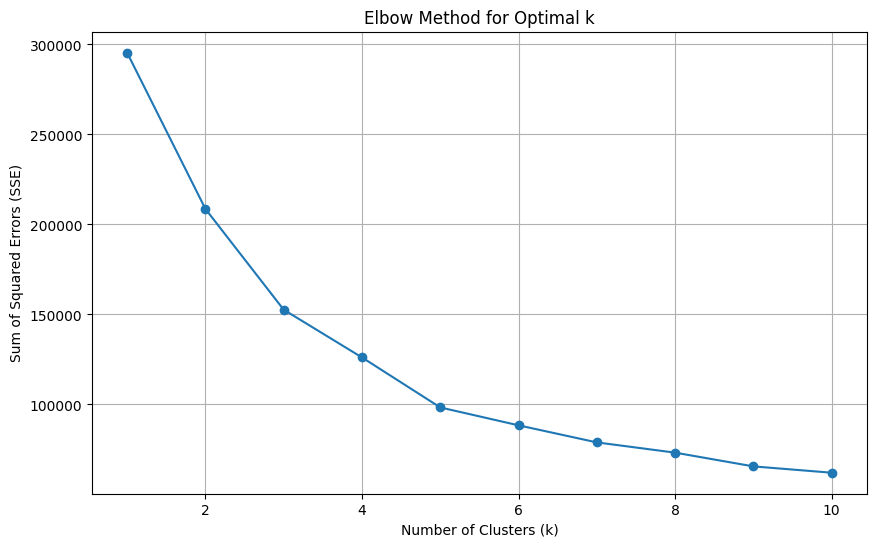

In [ ]:
sum_squared_errors = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    sum_squared_errors.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sum_squared_errors, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid(True)
plt.show()

The Elbow Method plot shows that the Sum of Squared Errors (SSE) decreases rapidly as the number of clusters increases, with the most noticeable bend occurring at k = 4. This "elbow point" indicates that adding more clusters beyond four results in diminishing returns in reducing SSE. Therefore, the optimal number of clusters for this dataset is likely 4.

#### Applying KMeans clustering on this matrix

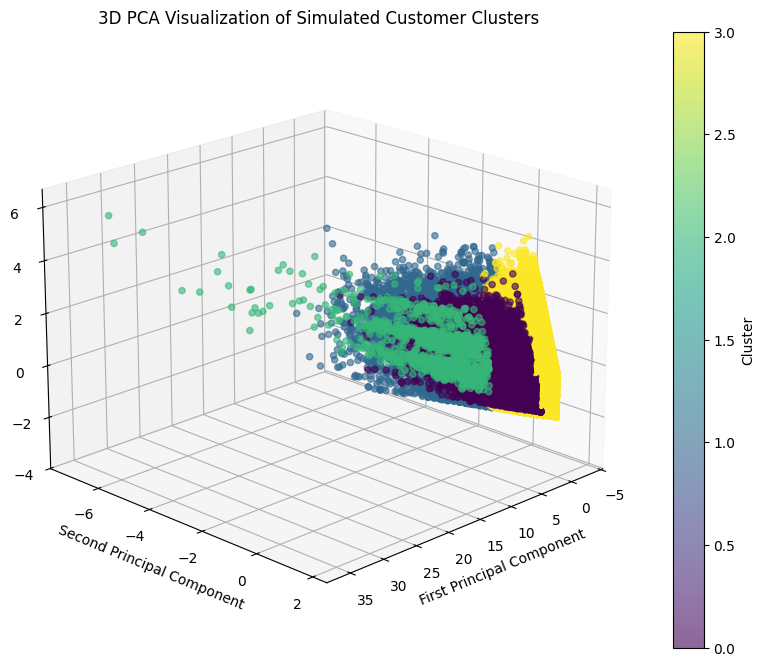

In [ ]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters = 4, random_state = 42)
pca_df["cluster"] = kmeans.fit_predict(pca_df)

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_df['PC1'],
                     pca_df['PC2'],
                     pca_df['PC3'],
                     c=pca_df["cluster"],
                     cmap='viridis',
                     alpha=0.6)

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.set_title('3D PCA Visualization of Simulated Customer Clusters')
plt.colorbar(scatter, label='Cluster')
ax.view_init(elev=20, azim=45)

plt.show()

### Merge clusters back to original dataset

In [ ]:
user_features = user_features.reset_index()

# Add customer_id back to the PCA dataframe
pca_df['customer_id'] = user_features['customer_id']

# Merge cluster labels with the original dataset + add helpful_vote_ratio
df_reviews = df_reviews.merge(
    pca_df[['customer_id', 'cluster']],
    on='customer_id',
    how='left'
)

In [ ]:
df_reviews

,customer_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,...,time_since_last_purchase,parent_product_average_rating,product_id_average_rating,sum_helpfulvotes,sum_totalvotes,full_review,sentiments,purchases_last_4_years,monthly_purchase_frequency,cluster
0,11960,B00LCJAW06,219600481,Persian-Rugs T1007 Abstract Modern Area Rug Ca...,Furniture,4,1,1,N,Y,...,0,4.500000,4.500000,2,3,Quick delivery and quality Rug.. Delivered in ...,positive,5,0.104167,1
1,11960,B008OTSEXY,682436048,Flash Furniture High Back Black Ribbed Upholst...,Furniture,4,0,0,N,Y,...,0,4.384615,4.571429,2,3,Looks great and feels nice.. Very comfortable ...,positive,5,0.104167,1
2,11960,B00KJ15KGY,32170248,Jackson Pollock Inspired Coffee Glass Table w/...,Furniture,4,1,1,N,Y,...,0,4.500000,4.500000,2,3,Buy from these guys. They take what they do se...,positive,5,0.104167,1
3,11960,B008ZL49WQ,614364353,Eaze Lounge Chair,Furniture,4,0,1,N,Y,...,42,4.800000,4.000000,2,3,Pretty but Pricey. Chair is very pretty. A bit...,positive,5,0.104167,1
4,11960,B002WRGE5O,928204157,Walker Edison L-Shaped Glass Computer Desk,Furniture,3,0,0,N,Y,...,0,4.000000,3.500000,2,3,Desk quality is fine. Issues with predrilled h...,negative,5,0.104167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337024,53096363,B007ZT2KKM,653117475,Smart-UPS C,Electronics,5,4,5,N,Y,...,236,4.750000,4.761905,42,49,"Huge, heavy, but it does the job. I keep addin...",positive,12,0.250000,0
337025,53096363,B003YKY5DG,603073673,Rolland Office Chair Caster Wheel for Hardwood...,Furniture,5,1,1,N,Y,...,0,4.512500,4.651163,42,49,"Fits the chair, rolls nicely. I put off writin...",positive,12,0.250000,0
337026,53096363,B00093IIRA,814295574,Logitech Harmony 880 Advanced Universal Remote...,Electronics,5,1,1,N,Y,...,367,4.227273,4.227273,42,49,Wife approved!. My wife is the primary remote-...,positive,12,0.250000,0
337027,53096363,B00O2MB7BS,960251524,Danby products,Major Appliances,5,2,3,N,Y,...,264,4.875000,5.000000,42,49,"4.4CF Steel - Excellent quality, very flexible...",positive,12,0.250000,0


In [ ]:
df_reviews["cluster"].value_counts()

,count
cluster,
3,159141
0,86977
1,67635
2,23276


### Save to csv file

In [ ]:
# Saved to CSV
df_reviews.to_csv(os.path.join(data_dir, "filtered_reviews_with_features_and_clusters.csv"), index=False)

## Cluster Analysis

We aim to understand how users are segmented based on the behavioral features previously selected. This analysis provides valuable insights into how we can tailor recommendation strategies to better meet the needs of each user group in practical, real world applications.

In [ ]:
# Add cluster labels to user_features
user_features_with_cluster = user_features.merge(pca_df[['customer_id', 'cluster']], on='customer_id')
user_features_with_cluster

,customer_id,monthly_purchase_frequency,purchases_last_4_years,time_since_last_purchase,avg_star_rating,num_categories,temporal_purchase_sequence,positive_sentiment_ratio,helpful_vote_ratio,cluster
0,11960,0.104167,5.0,8.400000,3.800000,1,5,0.800000,0.133333,1
1,14298,0.125000,6.0,30.500000,3.833333,1,6,0.833333,0.166667,3
2,14408,0.125000,6.0,2.500000,5.000000,2,6,1.000000,0.000000,3
3,18514,0.145833,7.0,3.142857,4.714286,1,7,1.000000,0.142857,3
4,21007,0.187500,9.0,112.222222,3.555556,2,9,0.888889,0.092593,0
...,...,...,...,...,...,...,...,...,...,...
47644,53095923,0.104167,5.0,85.400000,3.200000,4,5,0.400000,0.200000,1
47645,53095958,0.187500,9.0,151.111111,4.555556,2,9,0.777778,0.101655,0
47646,53096191,0.187500,9.0,133.777778,4.333333,2,9,0.777778,0.102564,0
47647,53096229,0.166667,8.0,136.125000,3.000000,1,8,0.500000,0.095000,1


### Distribution of clusters

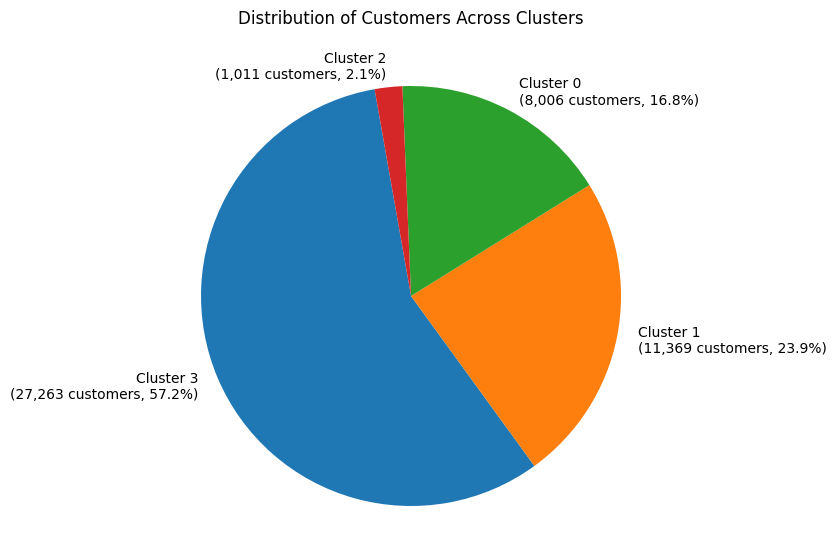

In [ ]:
# Drop duplicate rows with duplicate customer ids
customers = df_reviews.drop_duplicates(subset=["customer_id"], keep = 'first')
cluster_counts = customers['cluster'].value_counts()

# Pie Chart for cluster distributions
plt.figure(figsize=(10, 6))
plt.pie(cluster_counts.values, labels=[f"Cluster {i}\n({j:,} customers, {(j/len(customers)*100):.1f}%)" for i, j in cluster_counts.items()],
        autopct='',
        startangle=100,
        labeldistance=1.1)
plt.title("Distribution of Customers Across Clusters", pad = 30)
plt.axis("equal")
plt.show()

The pie chart shows the distribution of customers across the four clusters. Cluster 3 is the largest, containing 57.2% of customers, representing the dominant user behavior. Cluster 1 follows with 23.9%, forming a significant secondary segment. Cluster 0 makes up 16.8%, suggesting a smaller but distinct group. Cluster 2 is the smallest at 2.1%, potentially capturing unique or outlier behaviors. This segmentation highlights the varying sizes of behavioral groups within the customer base.

### monthly_purchase_frequency

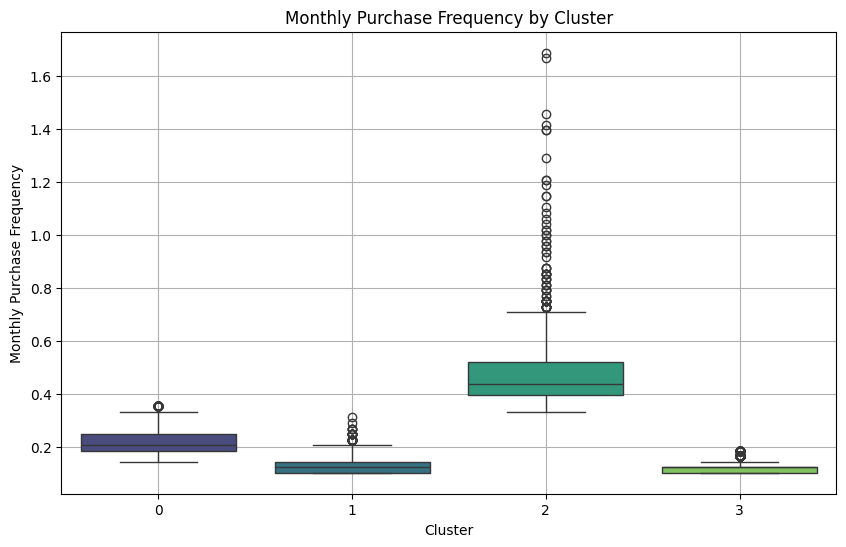

Monthly purchase frequency statistics by cluster:


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,8006.0,0.23,0.05,0.15,0.19,0.21,0.25,0.35
1,11369.0,0.12,0.03,0.10,0.10,0.12,0.15,0.31
2,1011.0,0.48,0.16,0.33,0.40,0.44,0.52,1.69
3,27263.0,0.12,0.02,0.10,0.10,0.12,0.12,0.19


In [ ]:
# Plot monthly_purchase_frequency by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='monthly_purchase_frequency', data=user_features_with_cluster, palette='viridis')
plt.title('Monthly Purchase Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monthly Purchase Frequency')
plt.grid(True)
plt.show()

# Summary Statistics
print("Monthly purchase frequency statistics by cluster:")
monthly_freq_summary = user_features_with_cluster.groupby('cluster')['monthly_purchase_frequency'].describe().round(2)
monthly_freq_summary

The boxplot reveals distinct customer segments based on their monthly shopping activity.

Cluster 2 has the highest purchase frequency, with a mean of 0.48 and several high-value outliers, which could indicate a group of highly active buyers.

Cluster 0 follows with a moderate mean of 0.21, suggesting occasional but consistent engagement.

Clusters 1 and 3 show lower purchase frequency, both with a mean of 0.12, reflecting infrequent purchasing behaviour.

### purchases_last_4_years

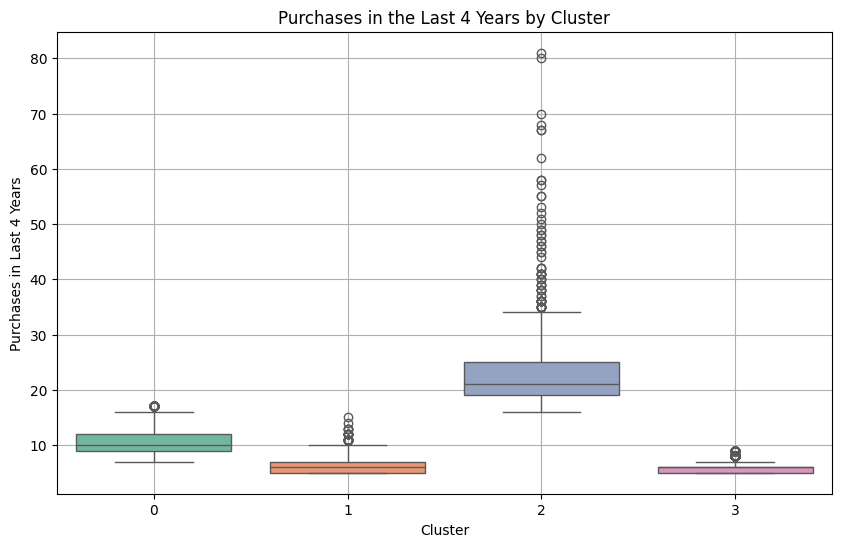

Last 3 years purchases statistics by cluster:


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,8006.0,10.86,2.18,7.0,9.0,10.0,12.0,17.0
1,11369.0,5.95,1.23,5.0,5.0,6.0,7.0,15.0
2,1011.0,23.02,7.53,16.0,19.0,21.0,25.0,81.0
3,27263.0,5.84,0.98,5.0,5.0,6.0,6.0,9.0


In [ ]:
# Plot purchases_last_4_years by cluster

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='purchases_last_4_years', data=user_features_with_cluster, palette='Set2')
plt.title('Purchases in the Last 4 Years by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Purchases in Last 4 Years')
plt.grid(True)
plt.show()

# Summary statistics
print("Last 3 years purchases statistics by cluster:")
purchases_last3_summary = user_features_with_cluster.groupby('cluster')['purchases_last_4_years'].describe().round(2)
purchases_last3_summary

The boxplot shows clear differences in customer purchase behavior across clusters

Cluster 2 has the highest purchase volume, with a mean of 23.02 and a wider spread, which once again could indicate a group of high-frequency buyers.

Cluster 0 shows moderate activity, with a mean of 10.86.

Clusters 1 and 3 both display lower purchasing behaviour, with means of 5.95 and 5.84 respectively as well as limited variability.

The boxplot overall indicates that customers are meaningfully segmented based on their long-term purchase activity.

###  time_since_last_purchase

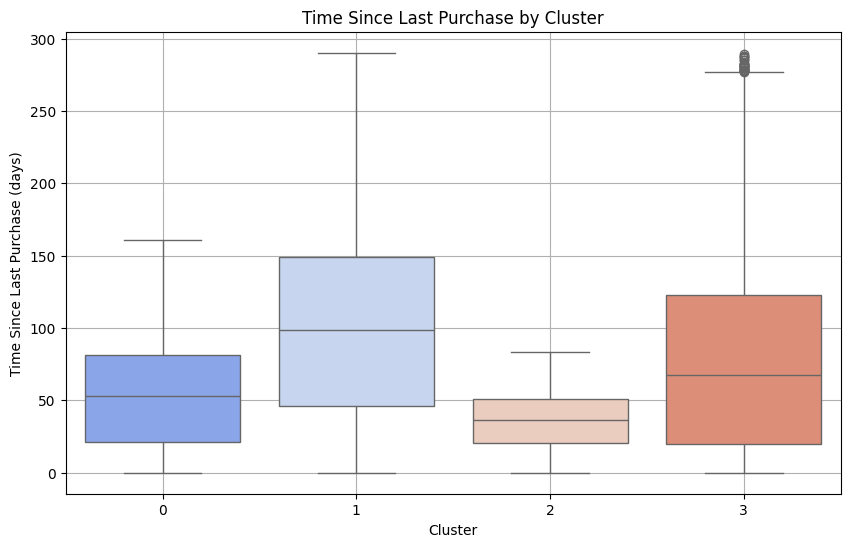

Time since last purchase statistics by cluster:


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,8006.0,53.67,37.28,0.0,21.50,53.16,81.14,161.00
1,11369.0,101.44,67.45,0.0,46.17,98.38,149.20,290.20
2,1011.0,36.55,20.03,0.0,20.63,36.72,51.16,83.71
3,27263.0,77.29,64.09,0.0,20.00,67.50,122.80,289.00


In [ ]:
# Plot time_since_last_purchase by cluster

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='cluster',
    y='time_since_last_purchase',
    data=user_features_with_cluster,
    palette='coolwarm'
)
plt.title('Time Since Last Purchase by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Time Since Last Purchase (days)')
plt.grid(True)
plt.show()

# Summary statistics
print("Time since last purchase statistics by cluster:")
time_since_last_purchase_summary = user_features_with_cluster.groupby('cluster')['time_since_last_purchase'].describe().round(2)
time_since_last_purchase_summary

The boxplot shows that time since last purchase varies significantly across clusters, indicating different levels of customer engagement.

Cluster 2 stands out with the shortest time since last purchase with a mean of 36.55 days.

Cluster 0 also shows relatively recent activity with a mean of 53.67 days.

Cluster 1 has the longest gap since last purchase with a mean of 101.44 days which could indicate potential churn or dormancy.

Cluster 3 lies in between but with high variability.

### helpful_vote_ratio

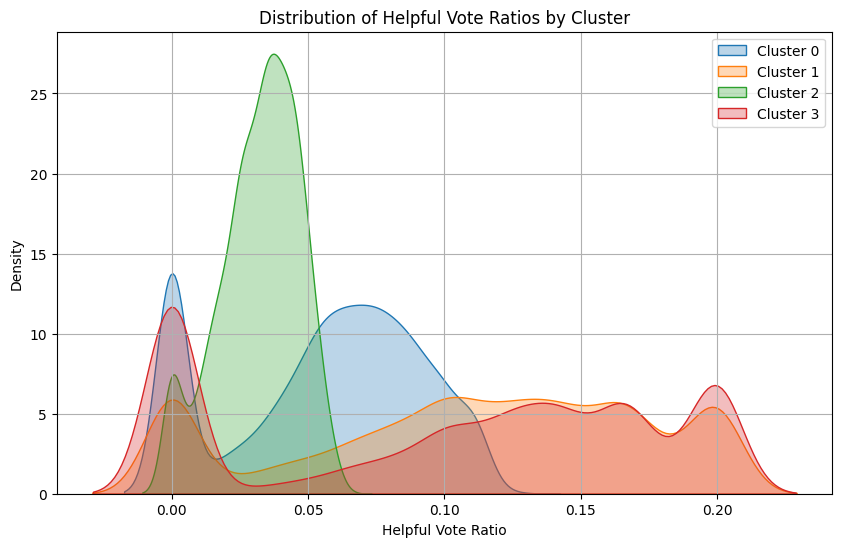

In [ ]:
# KDE plot for helpful vote ratio

plt.figure(figsize=(10, 6))
for cluster in sorted(user_features_with_cluster['cluster'].unique()):
    sns.kdeplot(
        data=user_features_with_cluster[user_features_with_cluster['cluster'] == cluster],
        x='helpful_vote_ratio',
        label=f'Cluster {cluster}',
        fill=True,
        alpha=0.3
    )
plt.title('Distribution of Helpful Vote Ratios by Cluster')
plt.xlabel('Helpful Vote Ratio')
plt.legend()
plt.grid(True)
plt.show()

The KDE plot shows that helpful vote ratios vary significantly across cluster_counts

Cluster 1 shows the highest overall helpful vote ratios, with a broad distribution extending well beyond 0.15, suggesting this group contributes many reviews perceived as helpful.

Cluster 3 also has a long right tail, indicating a small subset of highly helpful reviewers, though the majority are centered around lower values.

Cluster 0 has a moderate peak between 0.05 and 0.10, suggesting generally helpful but not outstanding review behavior.

Cluster 2 has the narrowest peak, centered around 0.04, indicating that their reviews are the least likely to be marked as helpful.

This distribution highlights Clusters 1 and 3 as having higher potential influence through review content.

### avg_star_rating

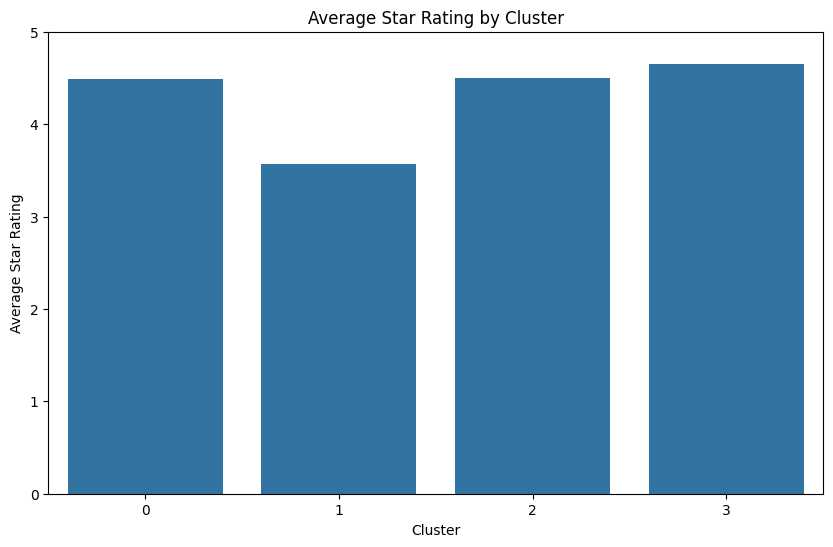

Average Star Rating statistics by cluster:


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,8006.0,4.49,0.42,2.54,4.22,4.56,4.86,5.0
1,11369.0,3.57,0.53,1.00,3.33,3.67,4.00,5.0
2,1011.0,4.50,0.42,2.57,4.25,4.60,4.83,5.0
3,27263.0,4.65,0.33,3.17,4.40,4.67,5.00,5.0


In [ ]:
# Bar plot for average star rating

plt.figure(figsize=(10, 6))
sns.barplot(
    x='cluster',
    y='avg_star_rating',
    data=user_features_with_cluster,
    estimator=np.mean,
    ci=None,
)
plt.title('Average Star Rating by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Star Rating')
plt.ylim(0, 5)  # Star ratings are usually 1 to 5
plt.show()

# Summary statistics
print("Average Star Rating statistics by cluster:")
avg_star_rating_summary = user_features_with_cluster.groupby('cluster')['avg_star_rating'].describe().round(2)
avg_star_rating_summary

The bar plot shows the average product rating (from 1 to 5 stars) given by customers in each cluster.

The bar chart shows that most clusters tend to give high average star ratings, with the exception of Cluster 1, which stands out with the lowest average rating of 3.57. This suggests customers in Cluster 1 may be more critical or less satisfied.

Cluster 3 gives the highest average rating of 4.65, followed closely by Cluster 2 (4.50) and Cluster 0 (4.49), indicating a generally positive sentiment in these groups.

### num_categories

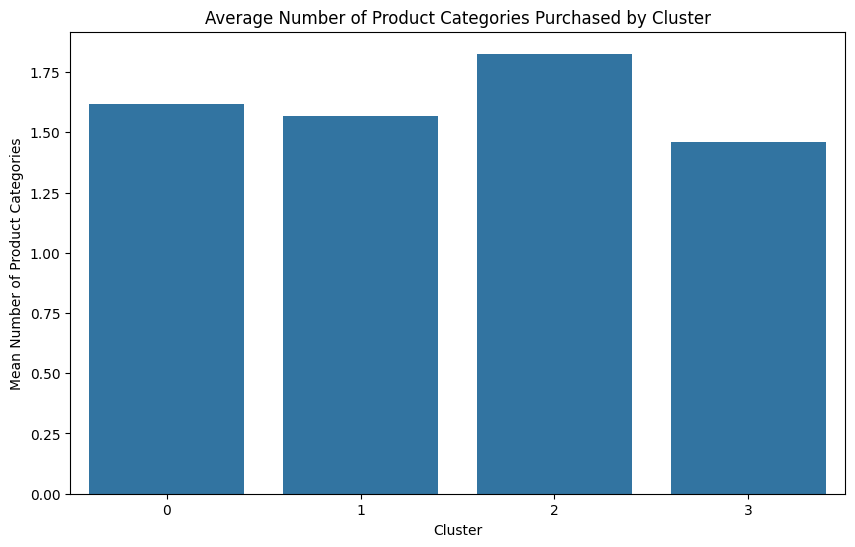

In [ ]:
# Bar plot for average number of categories

plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='num_categories', data=user_features_with_cluster, estimator=np.mean, ci=None)
plt.title('Average Number of Product Categories Purchased by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Number of Product Categories')
plt.show()

The bar plot shows the average number of unique product categories purchased by customers in each cluster

The chart shows that Cluster 2 purchases from the widest variety of product categories, suggesting more diverse shopping behavior.

Clusters 0 and 1 follow closely behind with averages around 1.6, indicating moderate diversity in product interest.

Cluster 3 has the lowest average, suggesting customers in this group tend to shop within fewer, possibly niche categories.

### temporal_purchase_sequence

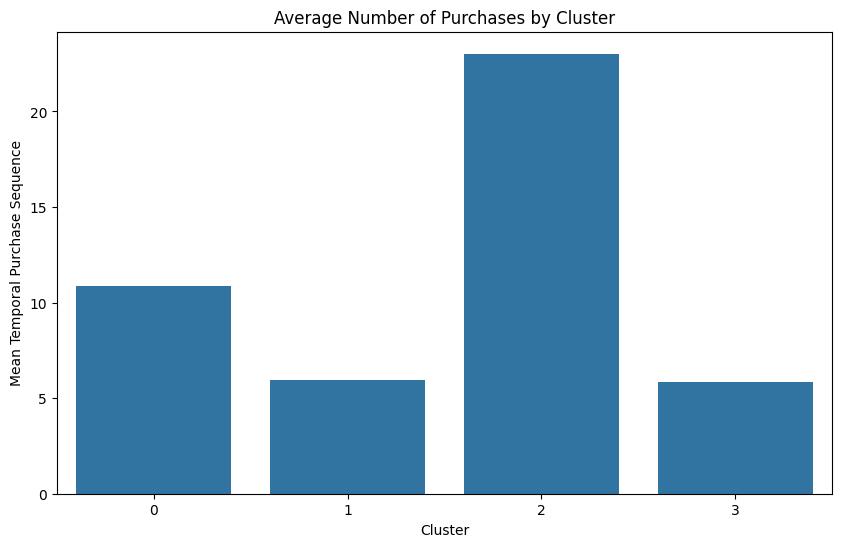

In [ ]:
# Bar plot for average number of purchases

plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='temporal_purchase_sequence', data=user_features_with_cluster, estimator=np.mean, ci=None)
plt.title('Average Number of Purchases by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Temporal Purchase Sequence')
plt.show()

The bar plot shows the average number of purchases made by customers in each cluster.

Cluster 2 has the highest average number of purchases, indicating a highly engaged and active segment.

Cluster 0 follows with a moderate average of around 11 purchases, suggesting steady but less intensive engagement.

In contrast, Clusters 1 and 3 both average around 6 purchases, highlighting them as less active customer groups.


### positive_sentiment_ratio

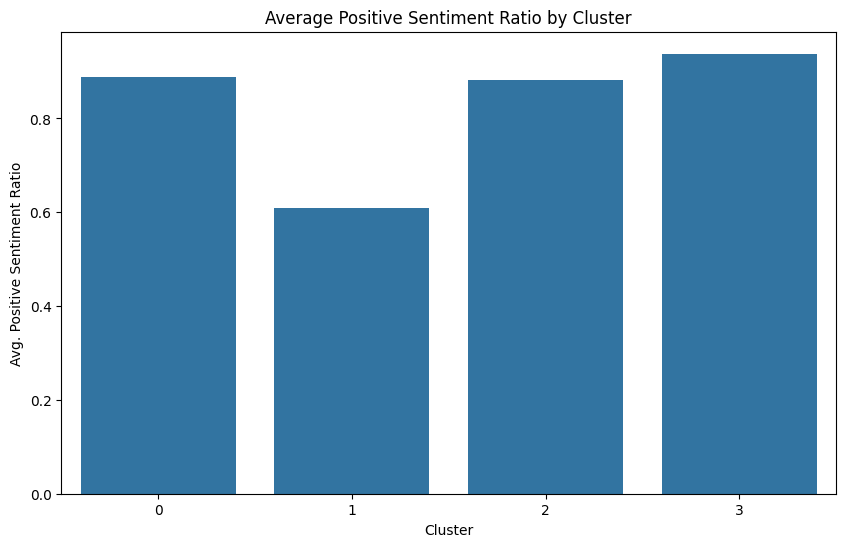

In [ ]:
# Bar plot for average positive sentiment ratio

plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='positive_sentiment_ratio', data=user_features_with_cluster, estimator=np.mean, ci=None)
plt.title('Average Positive Sentiment Ratio by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Avg. Positive Sentiment Ratio')
plt.show()

The bar chart shows the average positive sentiment ratio across the 4 different clusters.

Clusters 0, 2, and 3 all have a high average positive sentiment ratio, each exceeding 0.8, indicating that users in these clusters tend to leave mostly positive reviews.

In contrast, Cluster 1 stands out with the lowest average ratio of around 0.6, suggesting more critical or mixed sentiment among its users.

This implies that while most clusters reflect a generally satisfied user base, Cluster 1 may include more dissatisfied or discerning customers.

## Summary Statistics Across Clusters

In [ ]:
summary_statistics = pd.DataFrame()

for cluster in user_features_with_cluster['cluster'].unique():
    cluster_data = user_features_with_cluster[user_features_with_cluster['cluster'] == cluster]

    summary_statistics[f'Cluster_{cluster}'] = pd.Series({
        'total_customers': len(cluster_data),
        'avg_monthly_purchase_frequency': cluster_data['monthly_purchase_frequency'].mean(),
        'avg_purchases_last_4_years': cluster_data['purchases_last_4_years'].mean(),
        'avg_time_since_last_purchase': cluster_data['time_since_last_purchase'].mean(),
        'avg_helpful_vote_ratio': cluster_data['helpful_vote_ratio'].mean(),
        'avg_star_rating': cluster_data['avg_star_rating'].mean(),
        'avg_num_categories': cluster_data['num_categories'].mean(),
        'avg_temporal_purchase_sequence': cluster_data['temporal_purchase_sequence'].mean(),
        'avg_positive_sentiment_ratio': cluster_data['positive_sentiment_ratio'].mean()
    })

# Sort by cluster number
sorted_summary_statistics = summary_statistics[sorted(summary_statistics.columns, key=lambda x: int(x.split('_')[-1]))]

print("Summary Statistics of Clusters:")
sorted_summary_statistics.round(2)

Summary Statistics of Clusters:


,Cluster_0,Cluster_1,Cluster_2,Cluster_3
total_customers,8006.00,11369.00,1011.00,27263.00
avg_monthly_purchase_frequency,0.23,0.12,0.48,0.12
avg_purchases_last_4_years,10.86,5.95,23.02,5.84
avg_time_since_last_purchase,53.67,101.44,36.55,77.29
avg_helpful_vote_ratio,0.06,0.11,0.03,0.10
avg_star_rating,4.49,3.57,4.50,4.65
avg_num_categories,1.62,1.57,1.83,1.46
avg_temporal_purchase_sequence,10.86,5.95,23.02,5.84
avg_positive_sentiment_ratio,0.89,0.61,0.88,0.94


## Customer Segmentation

### Cluster 0: Steady and Satisfied

Moderate group (8,006 customers) that engages fairly frequently and leaves consistently positive feedback.

  - Moderate average monthly purchase frequency (0.23)
  - Moderate average purchases over the last 4 years (10.86)
  - Moderate average time since last purchase (53.67)
  - Moderate helpful vote ratio (0.06)
  - Moderate average star rating (4.49)
  - Moderate average number of categories (1.62)
  - Moderate temporal purchase sequence (10.86)
  - Moderate - High average positive sentiment ratio (0.89)

Customers in this cluster engage at a steady pace, shop across a moderate range of products, and leave mostly positive reviews. While they are not the highest spenders, they form a loyal core and respond well to ongoing engagement.

### Cluster 1: Critical and Disengaged

Moderate group (11,369 customers) that shops infrequently and have lower satisfaction levels

  - Joint lowest average monthly purchase frequency (0.12)
  - Low average purchases over the last 4 years (5.95)
  - Highest average time since last purchase (101.44)
  - Highest helpful vote ratio (0.11)
  - Lowest average star rating (3.57)
  - Low - Moderate average number of categories (1.57)
  - Low temporal purchase sequence (5.95)
  - Lowest average positive sentiment ratio (0.61)

Customers in this cluster shop infrequently and tend to be more critical and dissatisfied. However, their feedback is often detailed and valued. This cluster has the highest risk of customer churn.

### Cluster 2: High-Value Power Buyers

Small group (1,011 customers) consisting of most engaged and potentially valuable customers.

  - Highest average monthly purchase frequency (0.48)
  - Highest average purchases over the last 4 years (23.02)
  - Lowest average time since last purchase (36.55)
  - Lowest helpful vote ratio (0.03)
  - High average star rating (4.50)
  - Highest average number of categories (1.83)
  - Highest temporal purchase sequence (23.02)
  - High average positive sentiment ratio (0.88)

Customers in this cluster shop frequently, review positively, and show interest across many categories.

### Cluster 3: Casual Optimists

Large group (27,263 customers) with infrequent but highly satisfied customers

  - Joint Lowest average monthly purchase frequency (0.12)
  - Lowest average purchases over the last 4 years (5.84)
  - Moderate average time since last purchase (77.29)
  - High helpful vote ratio (0.10)
  - Highest average star rating (4.65)
  - Lowest average number of categories (1.46)
  - Lowest temporal purchase sequence (5.84)
  - Highest average positive sentiment ratio (0.94)

Customers in this cluster are mostly occasional buyers who love what they get. While their activity is low, their sentiment is the most positive.

# Split into Test, Train, Validation Data

In [ ]:
 def chronological_split_with_val(data, train_ratio=0.7, val_ratio=0.15):
    train_data = []
    val_data = []
    test_data = []

    for user_id, group in data.groupby('customer_id'):
        group = group.sort_values('review_date')
        n = len(group)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)

        if train_end > 0 and val_end > train_end and n - val_end > 0:
            train_data.append(group.iloc[:train_end])
            val_data.append(group.iloc[train_end:val_end])
            test_data.append(group.iloc[val_end:])

    return (
        pd.concat(train_data, ignore_index=True),
        pd.concat(val_data, ignore_index=True),
        pd.concat(test_data, ignore_index=True)
    )

df_reviews = pd.read_csv(os.path.join(data_dir, "filtered_reviews_with_features_and_clusters.csv"))

customer_encoder = LabelEncoder()
product_encoder = LabelEncoder()

df_reviews['customer_id'] = customer_encoder.fit_transform(df_reviews['customer_id'])
df_reviews['product_id'] = product_encoder.fit_transform(df_reviews['product_id'])

df_reviews = df_reviews.sort_values(by = ['customer_id','review_date'])

train_data, val_data, test_data = chronological_split_with_val(df_reviews)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

## Print first 10 customers in Train, Test and Validation

In [ ]:
n_lines = 10;
for customer_id in train_customer_counts.index:
    train_count = train_customer_counts.loc[customer_id]
    test_count = test_customer_counts.loc[customer_id]
    val_count = val_customer_counts.loc[customer_id]
    total_count = train_count + test_count + val_count
    train_ratio = train_count / total_count
    test_ratio = test_count / total_count
    val_ratio = val_count / total_count
    print(f"Customer {customer_id}: Train - {train_count} ({train_ratio:.2f}), Test - {test_count} ({test_ratio:.2f}), Val - {val_count} ({val_ratio:.2f}")

    if n_lines == 0:
        break
    n_lines -= 1